In [30]:
import infrared as ir
import infrared.rna as rna
import matplotlib.pyplot as plt
import copy

In [31]:
import random
import math
import RNA
from RNA import energy_of_struct

In [32]:
def draw_logo(sequences,name=None):
    import logomaker as lm
    
    matrix = lm.alignment_to_matrix(sequences = sequences)
    logo = lm.Logo(matrix)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    logo.ax.xaxis.set_ticks_position('none')
    if name is not None:
        plt.savefig(name)
    plt.show()
    logo.ax.xaxis.set_tick_params(pad=-1)
    return sequences

def opt_draw_logo(sequences,name=None,num=10):
    try:
        draw_logo(sequences,name)
    except ModuleNotFoundError as e:
        print(e)

def assignments_to_seqs(xs):
    return [rna.ass_to_seq(x) for x in xs]

In [33]:
ir.def_function_class(
    'hammingdistance',
    lambda i,y: [i],
    lambda x,y: 0 if x==y else 1
    )

ir.def_function_class(
    'valuedistance',
    lambda i,y: [i],
    lambda x,y: abs(x-y) 
    )

In [34]:
class NeighborGenerator:
    def __init__(self, model,td,*, weight=0, distance = hammingdistance):
        self.model = copy.deepcopy(model)
        self.td = td
        self.weight = weight
        self.distance = distance
        self.sampler=None
        
    #private attributes   
    def set_distance(self,distance):
        self.distance = distance
        self.sampler = None
    
    def set_distance_weight(self, weight):
        self.weight = weight
        self.sampler = None     
    
    def _make_sampler(self):
        if self.sampler == None:
            model1 = copy.deepcopy(self.model)
            model1.add_functions([self.distance(i,val) for (i,val) in enumerate(self.origin.values())], 'added_func')
            model1.set_feature_weight(self.weight, 'added_func')
            self.sampler = ir.Sampler(model1)#, td_factory = ConstTDFactory(self.td))
        
    def set_origin(self, origin):
        self.origin = origin
        self.sampler = None
        
    def get_weight(self):
        return self.weight
    
    def get_sampler(self):
        return self.sampler
        
    def generate_neighbour(self):
        self._make_sampler()
        return self.sampler.sample()

    
class ConstTDFactory:
    """@brief TD factory returning a constant TD
    Allows to pass and reuse an already computed TD 
    """
    def __init__(self,td):
        self._td = td
    def create(self,_size,_dependencies):
        return self._td    
    

In [35]:
def optimize(model,const_td_factory, objective, steps, weight, distance, temp, start=None):
    
    sequences=[]
    
    ng = NeighborGenerator(model, const_td_factory)
    sampler = ir.Sampler(model)
    cur = sampler.sample() if start is None else start
    curval = objective(cur)
    best, bestval = cur, curval
    
    ng.set_distance(distance)
    ng.set_distance_weight(weight)
    
    for i in range(steps):
        ng.set_origin(cur)
        new = ng.generate_neighbour()
        newval = objective(new)
        print("Neighbour" + str(i) + ": " + rna.ass_to_seq(new) + ", value: " + str(newval))
        sequences.append((rna.ass_to_seq(new),newval))
        
        if (newval >= curval or random.random() <= math.exp((newval-curval)/temp)):
            cur, curval = new, newval
            if curval > bestval:
                best, bestval = cur, curval
                
    return (sequences, best, bestval)

In [36]:
def multi_defect(sequence, targets, xi=1):
    k = len(targets)
    fc = RNA.fold_compound(sequence)
    ee = fc.pf()[1]
    eos = [fc.eval_structure(target) for target in targets]
    diff_ee = sum(1/k * (eos[i] - ee) for i in range(k))
    diff_targets = sum(2/(k*(k-1)) * abs(eos[i]-eos[j])
        for i in range(k) for j in range(k) if i<j)
    return diff_ee + xi * diff_targets

Neighbour0: CCUUCGGUCCUCGGGGUCCCUUGCCGGGGUGGGGG, value: -11.63040542602539
Neighbour1: CCUUCGGUCCUCGGGGUCCCCUGCCGGGGUGGGGG, value: -9.200674057006836
Neighbour2: CCUUCGGUCCUCGGGGUCCCCUGCCGGGGUGGGGG, value: -9.200674057006836
Neighbour3: CCUUCGGCCCUCGGGGCCUCCUGCCGGGGUGGGGG, value: -9.44131024678548
Neighbour4: CCUUCGGCCCUCGGGGCCUCCUGCCGGGGUGGGGG, value: -9.44131024678548
Neighbour5: CCUUCGGCCCUCGGGGCCUCCUGCGGGGGUGGGGG, value: -10.01839542388916
Neighbour6: CCUUCGGCCCUCGGGGCCUCCUGCGGGGGUGGGGG, value: -10.01839542388916
Neighbour7: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGUGGGGG, value: -9.975451151529947
Neighbour8: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGUGGGGG, value: -9.975451151529947
Neighbour9: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGUGGGGG, value: -9.975451151529947
Neighbour10: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGCGGGGG, value: -8.98938496907552
Neighbour11: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGCGGGGG, value: -8.98938496907552
Neighbour12: CCCUCGGCCCUCGGGGCCUCCUGCGGGGGCGGGGG, value: -8.98938496907552
Neighbour13: CCCUCGGCCCUCGG

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


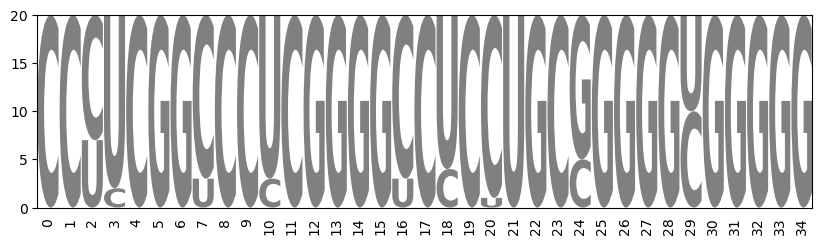

In [37]:
n=35
m=4

targets = ["((((((((((...))))((((....))))))))))",
           "((((((.((((((((....))))..))))))))))",
           ".((((((...)))))).(((((((....)))))))"]

model = ir.Model(n,m)
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')
model.set_feature_weight(1, 'gc')



for k, target in enumerate(targets):
    bps = rna.parse(target)
    model.add_constraints(rna.BPComp(i, j) for (i, j) in bps)
    model.add_functions([rna.BPEnergy(i, j, (i-1, j+1) not in bps)
    for (i, j) in bps], f'energy{k}')
    
original_sampler = ir.Sampler(model)
original_td = original_sampler.td
const_td_factory = ConstTDFactory(original_td)


steps = 20
temp = 40
weight = -2
objective = lambda x: - multi_defect(rna.ass_to_seq(x),targets,1)


iterations=1
distance = hammingdistance
weight = -4

for i in range(iterations):
    sequences, best,bestval = optimize(model,const_td_factory, objective, steps, weight, distance, temp, start=None)
    rna_sequences = [sequences[i][0] for i in range(len(sequences))]
    opt_draw_logo(rna_sequences)


Neighbours: Weight = -4
1: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
2: CCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
3: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
4: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
5: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
6: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGUCGGGG
7: UCUCGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
8: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
9: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
10: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
11: UCUCGGGCCCCCCGGGUUCCCGGCGGGGGCCGGGG
12: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
13: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
14: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
15: UCCUGGGUCCCCCGGGCCCCCGGCGGGGGCCGGGG
16: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
17: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
18: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
19: UCUUGGGUCCCUCGGGUUCCCGGCGGGGGCCGGGG
20: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
21: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
22: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
23: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
24: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
25: UCUUGGGUCCCCCGGGUUCCC

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


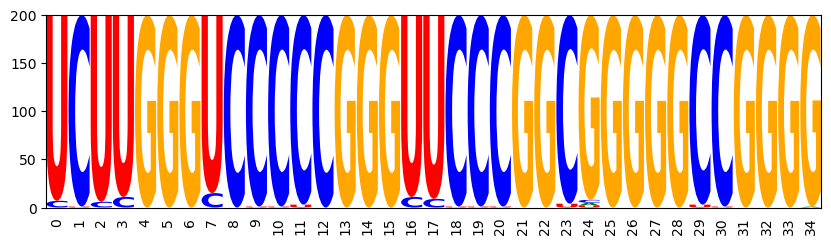

In [46]:
sampler = ir.Sampler(model)
origin = sampler.sample()

weight = -4
ng = NeighborGenerator(model, const_td_factory)
ng.set_distance_weight(weight)
ng.set_distance(hammingdistance)
ng.set_origin(origin)

rna_sequences=[]
iterations = 200

print("Neighbours: Weight = -4")
for i in range(iterations):
    neighbour = ng.generate_neighbour()
    rna_sequences.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    
opt_draw_logo(rna_sequences)

Neighbours: Weight = -7
1: AGGGUCCGGGGGGUUCGGGGGUCGUUCCCGGUUUU
2: GGGGCCCGGGGGGUUUGGGAGCCGCCUCUGGCUCC
3: GGGGCUUGGGGGGCCCGGAGGCUGACCUCGGCCUC
4: GGGGCCCGGGGGGUCCGGGGGCCGACUCCGGCUCC
5: GAGGCCCGGGGGGCUUGGGGGUCGUCUCUGGCUUU
6: GGGGCCCGGGGGGUCCGGGGGCCGCCUCCGGUCCU
7: GGGGCCCGGGGGGCCCGGGGGCCGAUCCCGGCCCU
8: GGGGCCCGGGGGGUUCGGGGGUCGCCCCCGGCCCC
9: GGGGUCCGGGGGGCUCGGAGGCUGCCCUCGGCCUC
10: GGGGCCCGGGGGGUCCGGGGGUCGCCCUUGGCCCC
11: GGGGUCCAGGGGGCCUGGGGGCUGUCUCUGGCCUU
12: GGGGUCCGGGGGGCCCGGGGGCCGCCUCUGGUCCC
13: GGGGCCUGGGGGGCCCGGGGGCCGAUUCCGGCUCC
14: GGAGUCCGGGGGGCUCGGGGGCCGUUUCCGGCUUC
15: GGGGCCCGGGGGGCCUGGGGGCCACCCCUGGUCCU
16: GAGGUCUGGGGGGCUUGGGGGCCGCCUCUGGCCUU
17: GGGGUCCGGAGGGUCCGGGGGCCGUCUCCGGCCUC
18: GGAAUCUGGGGGGUUCGGGGGCCGGCCUUGGUUCC
19: GGGGCCUGGGGGGCCCGGGGGCCGCUCCCGGCCCU
20: GGGGUUCGGGGGGUUUGGGGGCUGCCCCUGGCUCC
21: GGGGCUCGGGGGGCCCGGGGGCCGGCUCCGGCCCU
22: GGGGCCCGAGGGGCUCGGGGGUCGUCCUCGGCCCC
23: GGGGCUCGGGGGGCCCGAGGGCCACCUUUGGUUCU
24: GGGGCUCGGGGGGUUCGGAGGCCGUCCUCGGCCUC
25: GGGGUCUGGGGGGCUCAGGGG

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


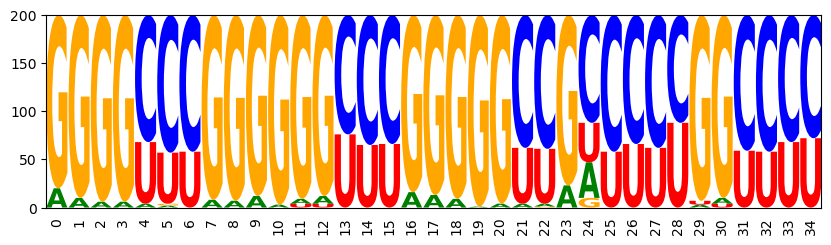

In [47]:
weight = 2
ng = NeighborGenerator(model, const_td_factory)
ng.set_distance_weight(weight)
ng.set_distance(hammingdistance)
ng.set_origin(origin)

rna_sequences2=[]
iterations = 200

print("Neighbours: Weight =2")
for i in range(iterations):
    neighbour = ng.generate_neighbour()
    rna_sequences2.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    
opt_draw_logo(rna_sequences2)

Neighbours: Weight = 1
1: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
2: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
3: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
4: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
5: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
6: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
7: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
8: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
9: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
10: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
11: UCUUGGGUCCCCCGGGCUCCCGGCGGGGGCCGGGG
12: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
13: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
14: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
15: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
16: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
17: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
18: UCUUGGGUCCCCCGGGCUCCCGGCGGGGGCCGGGG
19: UCUUGGGCCCCCCGGGUUCCCGGCGGGGGCCGGGG
20: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
21: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
22: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
23: UCUUGGGCCCCCCGGGUUCCCGGCGGGGGCCGGGG
24: UCUUGGGUCCCCCGGGUUCCCGGCGGGGGCCGGGG
25: UCUUGGGUCCCCCGGGUUCCCG

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


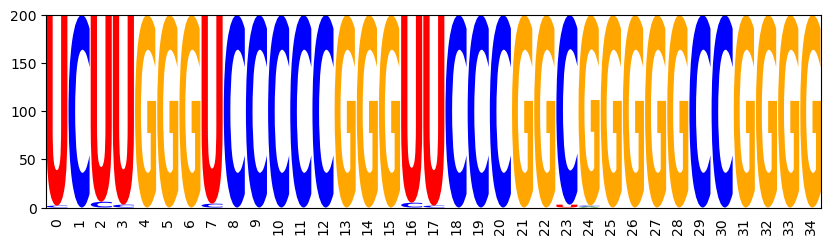

In [49]:
weight = -5
ng = NeighborGenerator(model, const_td_factory)
ng.set_distance_weight(weight)
ng.set_distance(hammingdistance)
ng.set_origin(origin)

rna_sequences3=[]
iterations = 200

print("Neighbours: Weight = 1")
for i in range(iterations):
    neighbour = ng.generate_neighbour()
    rna_sequences3.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    
opt_draw_logo(rna_sequences3)